# 0 - Quick Imports

In [1]:
import numpy as np
import PIL
from PIL import Image
import numpy as np
import torch
import os
import sys

sys.path.append('..')
os.chdir('..')
print(os.getcwd()) # confirm the working directory is the repo root

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/jas/project/alphagen/negtome


In [2]:
def display_alongside_batch(img_list, resize_dims=(512,512)):
    if isinstance(resize_dims, int):
        resize_dims = (resize_dims,resize_dims)
    res = np.concatenate([np.array(img.resize(resize_dims)) for img in img_list], axis=1)
    return Image.fromarray(res)

#  1 - SDXL + NegToMe

In [3]:
from src.negtome.pipeline_negtome_sdxl import StableDiffusionXLNegToMePipeline
pipe = StableDiffusionXLNegToMePipeline.from_pretrained("SG161222/RealVisXL_V4.0", torch_dtype=torch.float16)
pipe = pipe.to("cuda:2")

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.5.1+cu121 with CUDA 1201 (you have 2.4.1)
    Python  3.11.10 (you have 3.11.9)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

done ... updated attn processors


using prompt: a hyper-realistic digital painting of a woman

use_negtome: False


  0%|          | 0/50 [00:00<?, ?it/s]

use_negtome: False
Time taken: 22.08 seconds


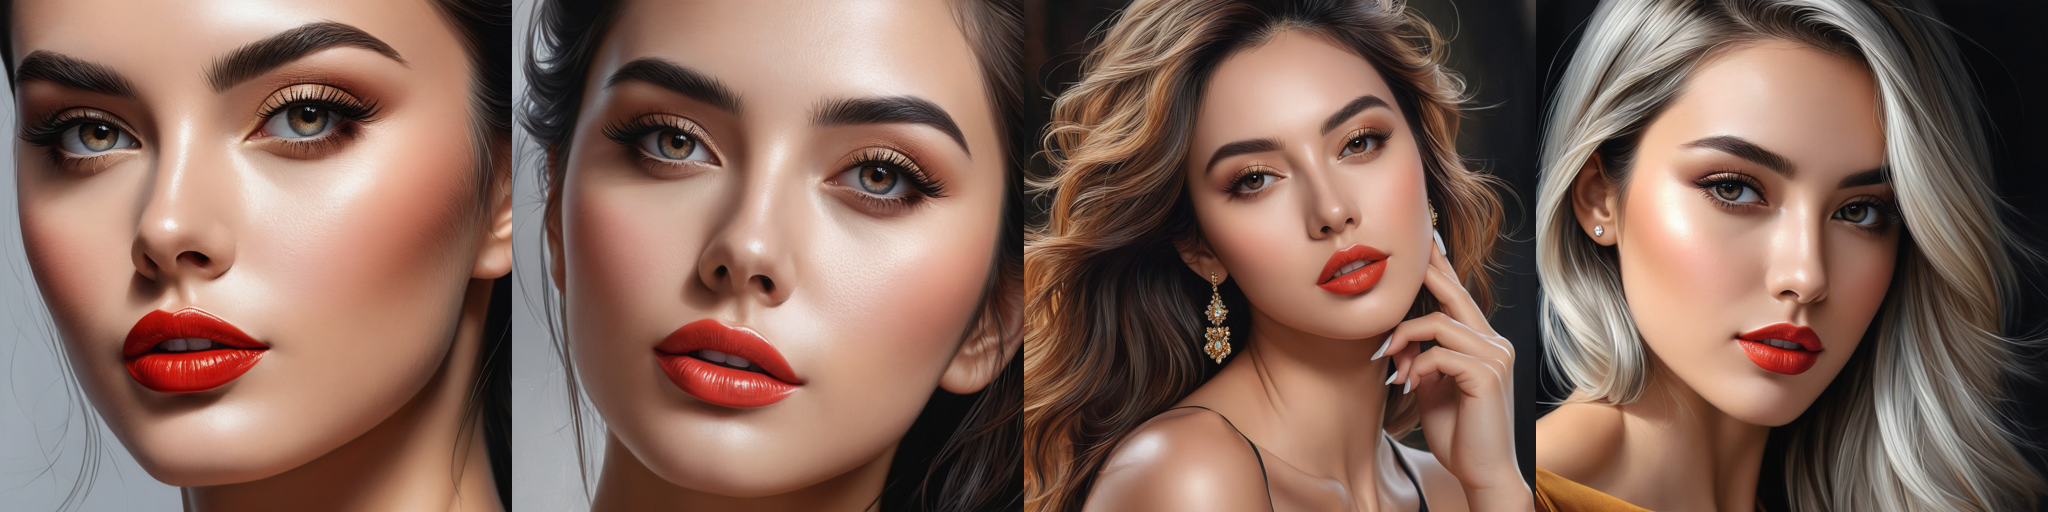


use_negtome: True


  0%|          | 0/50 [00:00<?, ?it/s]

use_negtome: True
Time taken: 22.16 seconds


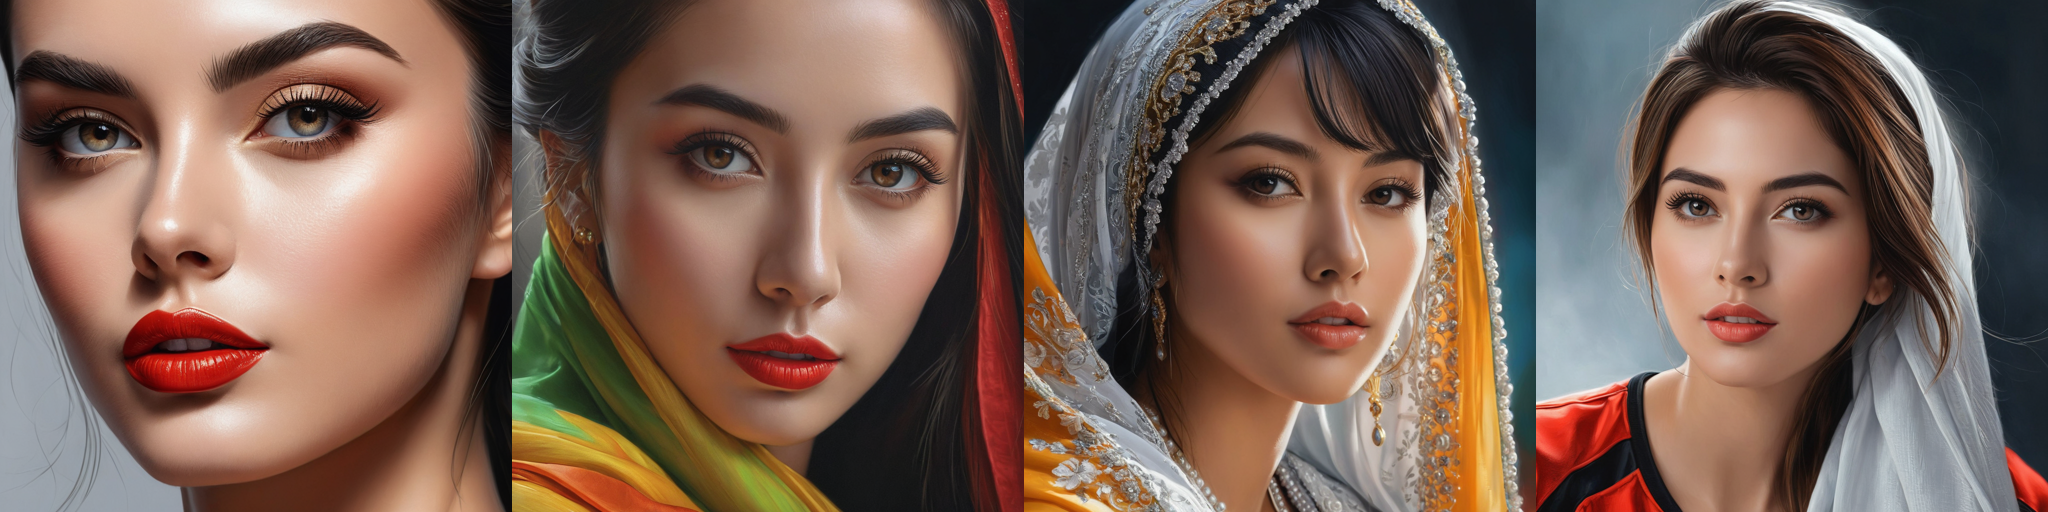


Percentage increase in inference time with negtome: 0.36%


In [4]:
# from diffusers.utils import logging
# logging.set_verbosity_debug()  # only show errors not warnings: https://huggingface.co/docs/diffusers/en/api/logging
import time

negtome_args = {
    'use_negtome': False,
    'merging_alpha': 1.9, #controls diversity: higher alpha pushes images further apart
    'merging_threshold': 0.7, #controls which features are pushed apart: higher threshold preserves original features more
    'merging_dropout': 0.,
    'merging_t_start': 950,
    'merging_t_end': 800,
}

# input prompt 
prompt = "a hyper-realistic digital painting of a woman"
# prompt = "a high resolution photo of a child"
# prompt = "A panda leaping up to catch a dumpling mid-air with its paws, surrounded by bamboo and a few steaming baskets of dumplings on the ground"
print (f"using prompt: {prompt}")

# hyperparameters
seed = 0 
num_inference_steps = 50
num_images_per_prompt = 4 # generate 4 images across the batch
height = width = 1024 
neg_prompt = "naked, deformed, bad anatomy, disfigured, poorly drawn face, mutation, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, blurry, watermarks, oversaturated, distorted hands, amputation"

# generate both with and w/o negtome
inference_times = []
for use_negtome in [False, True]:
    print(f"\nuse_negtome: {use_negtome}")
    generator = torch.Generator(pipe.device).manual_seed(seed)
    
    # Measure time
    start_time = time.time()
    images = pipe(
        prompt=prompt,
        guidance_scale=5.0,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        generator=generator,
        num_images_per_prompt=num_images_per_prompt,
        negative_prompt=neg_prompt,
        use_negtome=use_negtome,
        negtome_args=negtome_args,
    ).images
    elapsed_time = time.time() - start_time
    inference_times.append(elapsed_time)
    
    print(f"use_negtome: {use_negtome}\nTime taken: {elapsed_time:.2f} seconds")
    display(display_alongside_batch(images, resize_dims=512))

# Calculate percentage increase
percentage_increase = ((inference_times[1] - inference_times[0]) / inference_times[0]) * 100
print(f"\nPercentage increase in inference time with negtome: {percentage_increase:.2f}%")